## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [42]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [43]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [45]:
len(df['user_id'].value_counts())

290584

d. The proportion of users converted.

In [46]:
len(df.query('converted == 1'))/len(df['converted'])

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [47]:
len(df.query(('group == "treatment" & landing_page != "new_page"'))) + len(df.query(('group == "control" & landing_page != "old_page"')))

3893

f. Do any of the rows have missing values?

In [48]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [49]:
df_t = df.query(('group == "treatment" & landing_page == "new_page"'))
df_c = df.query(('group == "control" & landing_page == "old_page"'))
df2 = pd.concat([df_t, df_c])

In [50]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [51]:
len(df2['user_id'].unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [52]:
df2['user_id'].value_counts().head(1)

773192    2
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [53]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [54]:
df2 = df2.drop_duplicates()

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [55]:
len(df2.query('converted == 1'))/len(df2)

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [56]:
len(df2.query('group == "control" & converted == 1'))/len(df2.query('group == "control"'))


0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [57]:
len(df2.query('group == "treatment" & converted == 1'))/len(df2.query('group == "treatment"'))


0.11880724790277405

d. What is the probability that an individual received the new page?

In [58]:
len(df2.query('landing_page == "new_page"'))/len(df2['landing_page'])

0.5000636646764286

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

At this point I don't believe there is any evidence to suggest that one page leads to higher conversions than the other. Both samples are of similar size and they both fall pretty close to a 12% conversion rate.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_0: P_{new} - P_{old} \leq 0 \\
H_1: P_{new} - P_{old} > 0\\
\alpha = 0.05$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [59]:
# Compute new_page converted success rate under the null hypothesis
p_new = len(df2.query('converted == 1'))/len(df2['converted'])

#display new converted success rate
p_new


0.11959667567149027

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [60]:
# Compute old_page converted success rate under the null hypothesis
p_old = len(df2.query('converted == 1'))/len(df2['converted'])

# Display old converted success rate
p_old

0.11959667567149027

c. What is $n_{new}$?

In [61]:
# get new_page sample size from original data
n_new = len(df2.query('landing_page == "new_page"'))

n_new

145311

d. What is $n_{old}$?

In [62]:
# get old_page sample size from original data
n_old = len(df2.query('landing_page == "old_page"'))

n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [63]:
new_page_converted = df2.query('landing_page == "new_page"')['converted'].sample(n_new, replace = True)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [64]:
old_page_converted = df2.query('landing_page == "old_page"')['converted'].sample(n_old, replace = True)


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [65]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.00058806635718265665

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [66]:
p_diffs = []
df_new = df2.query('landing_page == "new_page"')['converted']
df_old = df2.query('landing_page == "old_page"')['converted']
for _ in range(10000):
    new_page_converted = df_new.sample(n_new, replace = True)
    old_page_converted = df_old.sample(n_old, replace = True)
    new_mean = new_page_converted.mean()
    old_mean = old_page_converted.mean()
    p_diffs.append(new_mean-old_mean)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

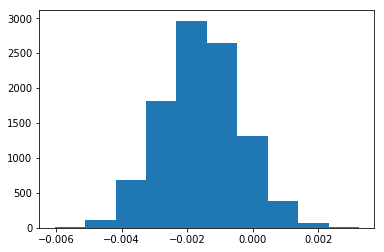

In [67]:
plt.hist(p_diffs);

Compute p-value

j. What proportion of the p_diffs are greater than the actual difference observed.

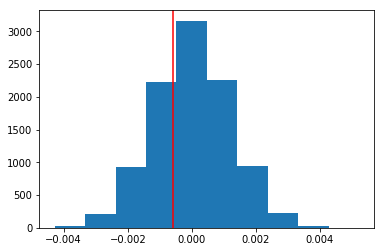

In [68]:
#create dist. under null hypothesis
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals);
plt.axvline(x=obs_diff, color = 'red');


P_value is much greater than 0.05 so we do not reject the null hypothesis.

In [69]:
(null_vals > obs_diff).mean()

0.69010000000000005

Under the null hypothesis, proportion of values greater than the observed difference is 0.69. 

k. In words, explain what you just computed in part j.. What is this value called in scientific studies? What does this value mean in terms of whether or not there is a difference between the new and old pages?

This value (0.69) is called the p-value. If the p-value is greater than our Alpha value, which is 0.05 in this case, we fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [70]:
import statsmodels.api as sm

convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [71]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')

In [72]:
z_score, p_value

(-1.3116075339133115, 0.90517370514059103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z score is a calculation of how many standard deviations the new group mean is away from the old group mean. In this case it is 1.31 standard deviations BELOW the old_page group. The p-vaule is 0.905 which suggests we should fail to reject the null. This is in line with our calculations in j and k.

Now lets check to see how long the test has been running.

In [73]:
min(df2['timestamp']), max(df2['timestamp'])

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

We can see above that the test has been running for approximately 3 weeks.


Conclusions

Based on the data given it is not suggested that the company change their landing page YET. Due to the fact that they have only been running the test for a few weeks and many people may initially dislike change, it is my reccomendation that they continue to run the test to see if the results change over time. At the moment the new and old pages have very similar conversion rates so having the new_page doesn't seem to be hurting in any way and it may prove to be more effective if run for a longer period of time.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Because our data observes whether or not someone is converted it woul be best in this case to use logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [74]:
#create intercept column and dummy columns for landing page.
df2['intercept'] = 1
df2[['new_page', 'old_page']] = pd.get_dummies(df['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [75]:
y = df2['converted']
X = df2[['intercept', 'new_page']]
lr = sm.Logit(y, X)
results = lr.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Sat, 20 Oct 2018   Pseudo R-squ.:               8.085e-06
Time:                        13:29:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
new_page      -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

Use the coefficient for 'new_page' above in the formula below.

$e^{-0.015} = 0.985$ 

Therefore, holding all other variables constant, a person is 0.985 times as likely to convert when using the new page. HOWEVER, with a p-value of 0.19, this value is not very significant.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The reason the p-value is different is because the p-value in logistic regression is not the chance of a type 1 error, it is the chance of a more extreme statistic.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The only other option i could think to add in is the general time of day each person was on our site, however, this information isnt relevent to the test as it has nothing to do with the change in website.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [76]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()
df3 = pd.merge(df2, df_countries, on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,CA


In [77]:
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])

In [78]:
lr = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK']])
results = lr.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            2
Date:                Sat, 20 Oct 2018   Pseudo R-squ.:               1.521e-05
Time:                        13:29:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1983
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.315      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [79]:
np.exp(-0.0408), np.exp(0.0099)

(0.96002111497165088, 1.0099491671175422)

Therefore people in CA were 0.96 times as likely as people in US to be converted. People in UK were 1.009 times as likely to be converted as people in US. However, with p-values well above 0.05, this is statistically insignicant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [80]:
#create new logistic model using US and old_page as baseline
lr = sm.Logit(df3['converted'], df3[['intercept', 'new_page', 'CA', 'UK']])
results = lr.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Sat, 20 Oct 2018   Pseudo R-squ.:               2.324e-05
Time:                        13:29:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
new_page      -0.0150      0.011     -1.308      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.744      0.457      -0.016       0.036
==============================================================================
"""

Running a logisitic regression test with everything together we can see that the results are essentially the same as when they were run separately.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [82]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0